In [1]:
from datetime import datetime, timedelta
from data import *
from window import *
import matplotlib.pyplot as plt
import numpy as np

ticker = 'AAPL'
start_date = (datetime.today() - timedelta(days=30)).strftime('%Y-%m-%d')
end_date = datetime.today().strftime('%Y-%m-%d')

stock_data = fetch_data(ticker, start_date, end_date)


price = stock_data['Close'][-1]
high = np.max(stock_data['High'])
low = np.min(stock_data['Low'])


print(stock_data.iloc[-5:][['EMA_5', 'EMA_8', 'EMA_13']])


[*********************100%%**********************]  1 of 1 completed
                          EMA_5       EMA_8      EMA_13
Datetime                                               
2024-04-26 14:45:00  169.808598  169.832993  169.904378
2024-04-26 15:00:00  169.894066  169.884551  169.927324
2024-04-26 15:15:00  169.926046  169.907985  169.936279
2024-04-26 15:30:00  169.914331  169.904188  169.929796
2024-04-26 15:45:00  169.706218  169.767700  169.838395


In [ ]:
data = fetch_data(ticker, start_date, end_date)

for row_index in range(2, len(data)):
    print(generate_signals(data, row_index))

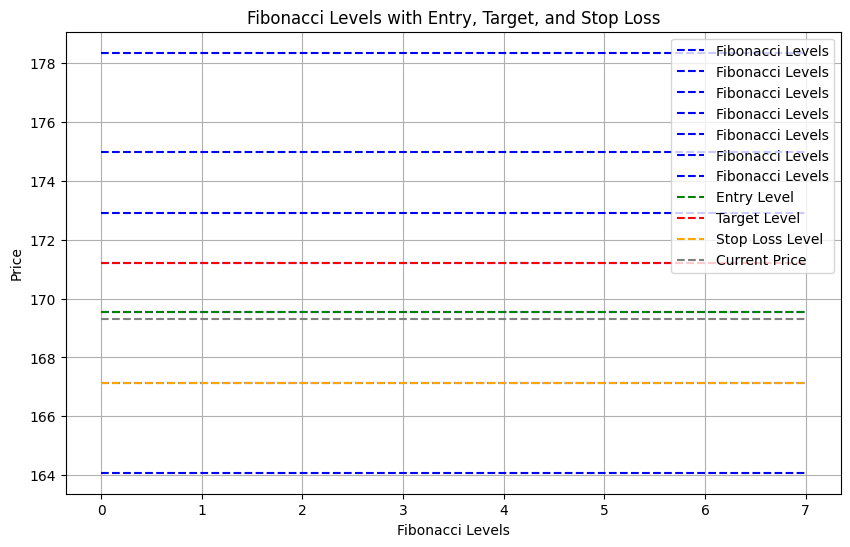

In [188]:
def generate_fibonacci_signals(price, fibonacci_levels):
    entry_level = min(fibonacci_levels, key=lambda x: abs(x - price))
    entry_level_index = fibonacci_levels.index(entry_level)
    
    if entry_level_index < len(fibonacci_levels) - 1:
        stop_loss_level = fibonacci_levels[entry_level_index + 1]
    else:
        stop_loss_level = None
    
    if entry_level_index > 0:
        target_level = fibonacci_levels[entry_level_index - 1]
    else:
        target_level = None
    
    return entry_level, target_level, stop_loss_level

fibonacci_levels = calculate_fibonacci_levels(high, low)
entry_level, target_level, stop_loss_level = generate_fibonacci_signals(price, fibonacci_levels)

plot_fibonacci_levels(price, fibonacci_levels, entry_level, target_level, stop_loss_level)

In [34]:
import matplotlib.pyplot as plt
import numpy as np

def plot_signals_with_prices(stock_data, macd_positions, signals):
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot stock prices
    ax.plot(stock_data.index, stock_data['Close'], color='blue', label='Stock Price')

    # Overlay buy and sell signals directly on the stock price line
    buy_positions = [macd_positions[i] for i in range(len(macd_positions)) if signals[i] == 1]
    sell_positions = [macd_positions[i] for i in range(len(macd_positions)) if signals[i] == -1]

    ax.scatter(buy_positions, stock_data.loc[buy_positions]['Close'], c='darkgreen', s=100, label='Buy Signal')
    ax.scatter(sell_positions, stock_data.loc[sell_positions]['Close'], c='darkred', s=100, label='Sell Signal')

    # Light green dots for signals between 0 and 1, and light red dots for signals between -1 and 0
    light_green_positions = [macd_positions[i] for i in range(len(macd_positions)) if 0 < signals[i] < 1]
    light_red_positions = [macd_positions[i] for i in range(len(macd_positions)) if -1 < signals[i] < 0]

    ax.scatter(light_green_positions, stock_data.loc[light_green_positions]['Close'], c='lightgreen', s=50)
    ax.scatter(light_red_positions, stock_data.loc[light_red_positions]['Close'], c='lightcoral', s=50)

    ax.legend()
    ax.set_title('Stock Prices with MACD Signals')
    ax.set_xlabel('Date')
    ax.set_ylabel('Stock Price')

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [35]:
from data import fetch_stock_prices
stock_data = fetch_stock_prices(ticker, start_date, end_date)

if stock_data is not None:
    # Call the function to generate signals
    macd_positions, signals = generate_signals(macd_data, rsi_data)

    # Plot the stock prices with signals
    plot_signals_with_prices(stock_data, macd_positions, signals)

[*********************100%%**********************]  1 of 1 completed


NameError: name 'generate_signals' is not defined

In [5]:
from datetime import datetime, timedelta
from data import *
from window import *
import matplotlib.pyplot as plt
import numpy as np

symbol = 'AAPL'
start_date = '2024-03-01'
end_date = '2024-04-25'

def generate_buy_sell_signal(symbol, start_date, end_date):
    # Fetch necessary data
    ema_data = calculate_emas(symbol, start_date, end_date)
    macd_data = fetch_macd(symbol, start_date, end_date)
    rsi_data = fetch_rsi(symbol, start_date, end_date)
    stock_data = fetch_stock_prices(symbol, start_date, end_date)
    if ema_data is None or macd_data is None or rsi_data is None or stock_data is None:
        return None

    # Generate EMA signals
    ema_signals = generate_ema_signals(ema_data)

    # Check for recent buy signal from EMA
    recent_ema_signal = ema_signals[-1][1] if ema_signals else ''

    # Generate MACD signals
    macd_signals = generate_macd_signals(macd_data)

    # Check for recent buy signal from MACD
    recent_macd_signal = macd_signals[-1][1] if macd_signals else ''

    # Generate RSI signals
    rsi_signals = generate_rsi_signals(rsi_data)

    # Check for recent RSI value
    recent_rsi = rsi_data['RSI'].iloc[-1]

    # Calculate high and low for Fibonacci levels
    high = stock_data['High'].max()
    low = stock_data['Low'].min()

    # Calculate Fibonacci levels
    fibonacci_levels = calculate_fibonacci_levels(high, low)

    # Check if within 3% of Fibonacci level
    current_price = stock_data['Close'].iloc[-1]
    nearest_fib_level = min(fibonacci_levels, key=lambda x: abs(x - current_price))
    three_percent_of_nearest = nearest_fib_level * 0.03
    within_three_percent = abs(current_price - nearest_fib_level) <= three_percent_of_nearest

    # Buy signal logic chain
    if recent_ema_signal == 'Buy' and recent_macd_signal == 'Buy' and recent_rsi < 35 and within_three_percent:
        entry_price = current_price
        stop_loss = fibonacci_levels[fibonacci_levels.index(nearest_fib_level) - 1]
        take_profit = fibonacci_levels[fibonacci_levels.index(nearest_fib_level) + 1]
        return {'action': 'Buy', 'entry_price': entry_price, 'stop_loss': stop_loss, 'take_profit': take_profit}
    else:
        return {'action': 'Sell'}

# Example usage
signal = generate_buy_sell_signal(symbol, start_date, end_date)
print(signal)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
{'action': 'Sell'}
